<a href="https://www.kaggle.com/code/ssalijoshua/eda-code?scriptVersionId=221752961" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [11]:
import pandas as pd
import numpy as np
import scipy.io
import h5py
import mne
import matplotlib.pyplot as plt

### Examining the structures inside the EEG_full

In [12]:
# Load the .mat file
file_path = "/kaggle/input/arousal/S01_F_CL_Sil_50_100.mat"  # Update with correct path
mat_data = h5py.File(file_path, 'r')

# Check if 'actualVariable' exists
if 'actualVariable' in mat_data:
    actual_var = mat_data['actualVariable']
    print("Keys inside actualVariable:", list(actual_var.keys()))
    
    # Check if 'EEG_full' exists inside 'actualVariable'
    if 'EEG_full' in actual_var:
        eeg_full = actual_var['EEG_full']
        print("Keys inside EEG_full:", list(eeg_full.keys()))
    else:
        print("'EEG_full' not found inside 'actualVariable'")
else:
    print("'actualVariable' not found in the dataset")


Keys inside actualVariable: ['EEG_full']
Keys inside EEG_full: ['chaninfo', 'chanlocs', 'comments', 'condition', 'data', 'dipfit', 'epoch', 'epochdescription', 'etc', 'event', 'eventdescription', 'filename', 'filepath', 'group', 'history', 'icaact', 'icachansind', 'icasphere', 'icasplinefile', 'icaweights', 'icawinv', 'nbchan', 'pnts', 'ref', 'reject', 'saved', 'session', 'setname', 'specdata', 'specicaact', 'splinefile', 'srate', 'stats', 'subject', 'times', 'trials', 'urchanlocs', 'urevent', 'xmax', 'xmin']


### Examining the chaninfo

In [13]:
if 'chaninfo' in eeg_full:
    eeg_data = eeg_full['chaninfo']
    print("Keys inside chaninfo:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chaninfo: ['filecontent', 'filename', 'icachansind', 'nodatchans', 'nosedir', 'plotrad', 'shrink']


### Examining chanlocs

In [14]:
if 'chanlocs' in eeg_full:
    eeg_data = eeg_full['chanlocs']
    print("Keys inside chanlocs:", list(eeg_data.keys()))
else:
    print("'data' not found inside 'EEG_full'")


Keys inside chanlocs: ['X', 'Y', 'Z', 'labels', 'radius', 'ref', 'sph_phi', 'sph_radius', 'sph_theta', 'theta', 'type', 'urchan']


### Combining the chanlocs

In [15]:
# Extract channel labels
channel_labels = []

chanlocs = eeg_full['chanlocs']

for ref in chanlocs['labels']:
    obj = mat_data[ref[0]]  # Dereference
    label = ''.join(map(chr, obj[:].flatten()))  # Convert to string
    channel_labels.append(label)

def extract_data(ref_array):
    """Extracts numeric data from HDF5 references, ensuring uniform shape."""
    values = []
    
    for ref in ref_array:
        obj = mat_data[ref[0]]  # Dereference
        
        data = obj[()]  # Extract value(s)
        if isinstance(data, np.ndarray):  
            data = data.flatten()  # Ensure it's 1D
            if data.size == 1:
                values.append(data[0])  # Append single value
            else:
                values.append(list(data))  # Append list if multiple values
        else:
            values.append(data)  # Append scalar directly
    
    return values  # Return list instead of NumPy array

# Convert fields into lists of numerical values
df_chanlocs = pd.DataFrame({
    "Channel": channel_labels,
    "X": extract_data(chanlocs['X']),
    "Y": extract_data(chanlocs['Y']),
    "Z": extract_data(chanlocs['Z']),
    "Theta": extract_data(chanlocs['theta']),
    "Sph_Phi": extract_data(chanlocs['sph_phi']),
    "Sph_Theta": extract_data(chanlocs['sph_theta']),
    "Sph_Radius": extract_data(chanlocs['sph_radius'])
})

# Display the cleaned DataFrame
df_chanlocs

,Channel,X,Y,Z,Theta,Sph_Phi,Sph_Theta,Sph_Radius
0,Fp1,0.950477,0.308829,-0.034899,-18.0,-2.0,18.0,1.0
1,AF7,0.787531,0.615286,-0.034899,-38.0,-2.0,38.0,1.0
2,AF3,0.884846,0.375595,0.275637,-23.0,16.0,23.0,1.0
3,F1,0.710264,0.286965,0.642788,-22.0,40.0,22.0,1.0
4,F3,0.673028,0.545007,0.5,-39.0,30.0,39.0,1.0
...,...,...,...,...,...,...,...,...
139,Flight-time,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
140,Course-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
141,FB-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"
142,Ring-type,"[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]","[0, 0]"


### Electrode placement

In [16]:
# Keep only rows where X, Y, Z are numbers (filter out metadata)
df_cleaned = df_chanlocs[df_chanlocs["X"].apply(lambda x: isinstance(x, float))]

df_cleaned


,Channel,X,Y,Z,Theta,Sph_Phi,Sph_Theta,Sph_Radius
0,Fp1,0.950477,0.308829,-0.034899,-18.0,-2.0,18.0,1.0
1,AF7,0.787531,0.615286,-0.034899,-38.0,-2.0,38.0,1.0
2,AF3,0.884846,0.375595,0.275637,-23.0,16.0,23.0,1.0
3,F1,0.710264,0.286965,0.642788,-22.0,40.0,22.0,1.0
4,F3,0.673028,0.545007,0.5,-39.0,30.0,39.0,1.0
...,...,...,...,...,...,...,...,...
59,P8,-0.587427,-0.808524,-0.034899,126.0,-2.0,-126.0,1.0
60,P10,-0.532714,-0.733218,-0.422618,126.0,-25.0,-126.0,1.0
61,PO8,-0.808524,-0.587427,-0.034899,144.0,-2.0,-144.0,1.0
62,PO4,-0.884846,-0.375595,0.275637,157.0,16.0,-157.0,1.0


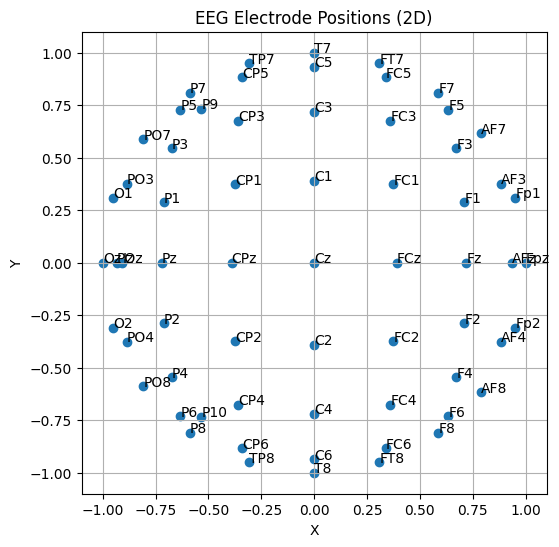

In [18]:
# Plot the electrode positions
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(df_cleaned['X'], df_cleaned['Y'], label='Electrodes')

for i, label in enumerate(df_cleaned['Channel']):
    ax.annotate(label, (df_cleaned['X'][i], df_cleaned['Y'][i]))

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('EEG Electrode Positions (2D)')
plt.grid(True)
plt.show()


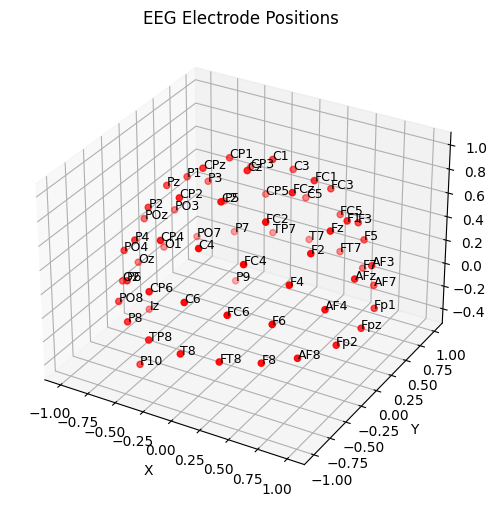

In [17]:
# Visualizing electrode placement

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Extract valid coordinates
x, y, z = df_cleaned["X"], df_cleaned["Y"], df_cleaned["Z"]

# Scatter plot
ax.scatter(x, y, z, c='r', marker='o')

# Label the points
for i, channel in enumerate(df_cleaned["Channel"]):
    ax.text(x.iloc[i], y.iloc[i], z.iloc[i], channel, fontsize=9)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_title("EEG Electrode Positions(3D)")

plt.show()


### Checking the labels

In [19]:
labels = extract_data(eeg_full['chanlocs']['labels'])
pd.DataFrame(labels)

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,70,112,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,65,70,55.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,65,70,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,70,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,70,51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,70,108,105.0,103.0,104.0,116.0,45.0,116.0,105.0,109.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,67,111,117.0,114.0,115.0,101.0,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
141,70,66,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,82,105,110.0,103.0,45.0,116.0,121.0,112.0,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Obtaining the data

In [20]:
if 'data' in eeg_full:
    eeg_data = eeg_full['data']
    eeg_data = pd.DataFrame(eeg_data)
    eeg_data

### Converting the data to a pandas dataframe

In [21]:

# Assign column names
eeg_data.columns = channel_labels

# Display the first few rows
eeg_data

,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,FC3,...,Head-raw-z,Head-x,Head-y,Head-z,Condition,Flight-time,Course-type,FB-type,Ring-type,LSL-time
0,-9.667615,-10.393621,-9.753345,-9.108747,-8.974578,-5.925375,-7.861744,-1.698606,-3.943043,-8.844296,...,0.956769,360.608093,356.855194,360.956757,6.2,62466.0,1.0,2.0,1.000000,21898.416016
1,-6.141129,-6.836845,-4.873523,-4.312459,-3.933507,-3.081656,-3.486265,1.742102,-0.792778,-3.365051,...,0.956769,360.608093,356.855194,360.956757,6.2,62466.0,1.0,2.0,1.000000,21898.419922
2,-4.675134,-4.363692,-0.448084,0.772359,0.550915,0.214158,-2.643757,-0.211528,1.913509,2.298281,...,0.957018,360.609161,356.857086,360.956879,6.2,62466.0,1.0,2.0,1.000000,21898.423828
3,-6.067291,-3.423522,-0.172872,1.712570,1.301004,1.842866,-5.526480,-4.801501,1.971172,3.726157,...,0.957268,360.611298,356.860901,360.957153,6.2,62466.0,1.0,2.0,1.000000,21898.427734
4,-9.710501,-6.376214,-4.447028,-1.877157,-2.537558,-1.611499,-7.792553,-6.148304,-1.637977,-0.723085,...,0.957517,360.613464,356.864685,360.957397,6.2,62466.0,1.0,2.0,1.000000,21898.431641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
441416,-16.771263,-1.611429,-9.319777,-9.373400,-6.722995,-5.973288,-12.990420,3.213263,-2.209813,-7.078461,...,1.951199,366.123444,359.607849,361.954285,6.5,62060.0,2.0,2.0,14.399902,25092.478516
441417,-19.246191,-4.546033,-9.070182,-9.906972,-7.394595,-7.195506,-13.011345,2.857405,-3.107048,-6.887184,...,1.945038,366.097504,359.598328,361.948120,6.5,62060.0,2.0,2.0,14.399902,25092.482422
441418,-19.239399,-9.205249,-12.321740,-12.276237,-10.223580,-9.013595,-7.696752,3.142329,-3.342923,-6.567175,...,1.938877,366.071564,359.588776,361.941956,6.5,62060.0,2.0,2.0,14.399902,25092.486328
441419,-18.326254,-13.053471,-16.411980,-14.846927,-12.995174,-9.925069,-3.790742,3.904310,-3.906003,-7.464587,...,1.005654,362.919220,358.921997,361.472260,6.5,62060.0,2.0,2.0,1.000000,25092.490234


In [22]:
 eeg_data.describe()

,Fp1,AF7,AF3,F1,F3,F5,F7,FT7,FC5,FC3,...,Head-raw-z,Head-x,Head-y,Head-z,Condition,Flight-time,Course-type,FB-type,Ring-type,LSL-time
count,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,...,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000,441421.000000
mean,-0.002238,0.006330,0.003392,0.005507,0.004104,0.005300,0.005868,0.007211,0.005776,0.005665,...,31.998072,361.190216,359.009064,361.075562,6.333631,68429.859375,1.452199,1.979713,2.241439,23613.615234
std,11.603650,9.732660,8.572510,7.614831,7.464170,7.279812,7.652548,7.821293,6.643475,6.063098,...,100.427605,5.215191,1.115968,1.029030,0.193339,12957.909180,0.496702,0.829074,4.050922,891.589539
min,-87.769409,-97.138115,-48.156540,-47.762119,-47.085369,-73.024338,-99.737900,-116.496704,-79.257004,-49.936390,...,-0.005709,315.225281,254.571030,263.341858,6.100000,34116.000000,1.000000,1.000000,1.000000,21898.416016
25%,-6.629619,-5.994308,-5.475246,-4.988505,-4.873827,-4.759687,-4.977228,-5.065335,-4.375896,-3.987508,...,0.686483,357.974762,358.350830,360.492188,6.200000,60062.000000,1.000000,1.000000,1.000000,22913.832031
50%,-0.679417,-0.370724,-0.235311,-0.044940,-0.076122,-0.070265,-0.032325,0.076122,-0.026245,-0.019628,...,1.200182,360.837067,359.042664,361.004456,6.300000,66317.000000,1.000000,2.000000,2.000000,23650.433594
75%,5.278647,5.330760,5.037460,4.866441,4.703454,4.628930,4.928057,5.145724,4.326827,3.936315,...,1.904484,364.192261,359.660370,361.606842,6.500000,84451.000000,2.000000,3.000000,2.000000,24365.417969
max,114.613678,93.120361,67.006897,53.871586,57.465363,57.192097,63.829643,93.060867,54.276924,54.904232,...,359.994110,388.409241,363.153839,364.047028,6.600000,86430.000000,2.000000,3.000000,108.000000,25092.494141


In [23]:
# Check for NaN or infinite values
print("Missing values:", np.isnan(eeg_data).sum())
print("Infinite values:", np.isinf(eeg_data).sum())


Missing values: Fp1            0
AF7            0
AF3            0
F1             0
F3             0
              ..
Flight-time    0
Course-type    0
FB-type        0
Ring-type      0
LSL-time       0
Length: 144, dtype: int64
Infinite values: Fp1            0
AF7            0
AF3            0
F1             0
F3             0
              ..
Flight-time    0
Course-type    0
FB-type        0
Ring-type      0
LSL-time       0
Length: 144, dtype: int64


### Sampling rate

In [24]:

sampling_rate = mat_data['actualVariable']['EEG_full']['srate'][()]
print("Sampling Rate:", sampling_rate)


Sampling Rate: [[256.]]


### One EEG channel over time

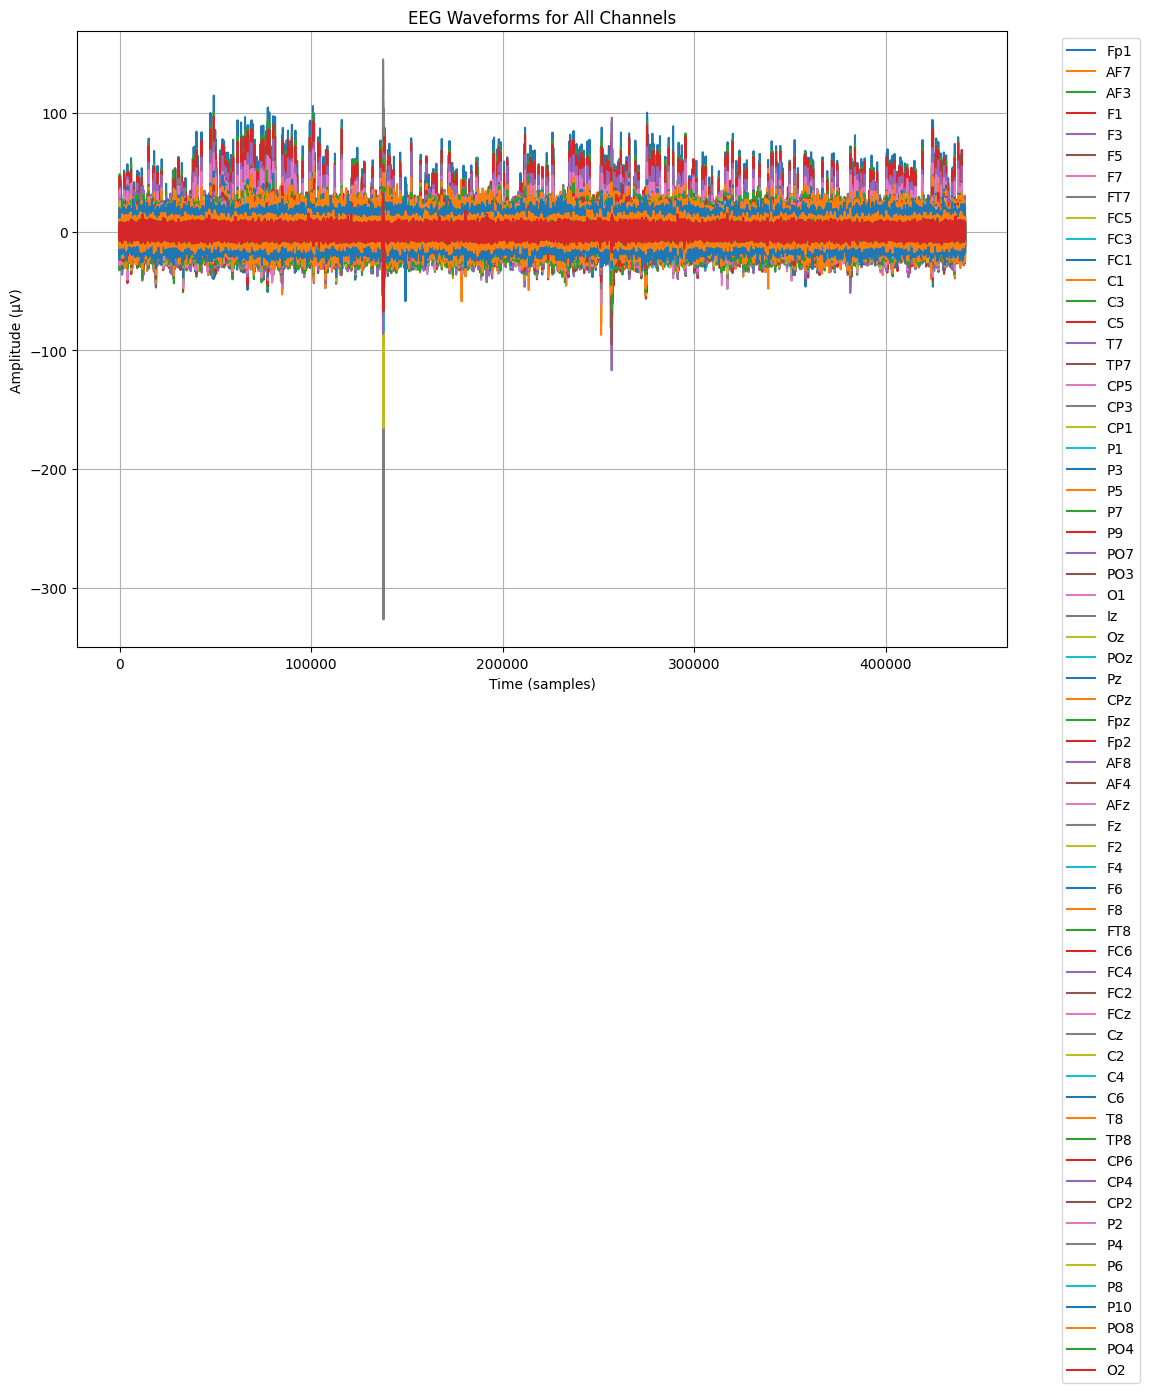

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming df_cleaned is your DataFrame with EEG data
# List of EEG channel names
channels = df_cleaned['Channel'].tolist()

# Select only the EEG channels and the time column (if applicable)
time_column = eeg_data.index  # Assuming the index is the time or you could use a specific column if you have a 'time' column.
eeg_data = eeg_data[channels]

# Plot all EEG waveforms on the same graph
plt.figure(figsize=(12, 8))

for channel in channels:
    plt.plot(time_column, eeg_data[channel], label=channel)

# Add labels and title
plt.xlabel('Time (samples)')
plt.ylabel('Amplitude (µV)')
plt.title('EEG Waveforms for All Channels')
plt.grid(True)

# Add a legend to differentiate the channels
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))

plt.show()

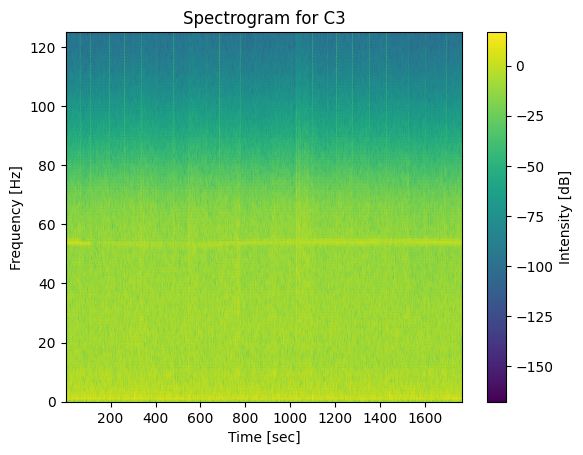

In [37]:
from scipy import signal
import matplotlib.pyplot as plt

# Example for a single channel
fs = 250  # Sampling frequency
f, t, Sxx = signal.spectrogram(eeg_data['C3'], fs)
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Spectrogram for C3')
plt.colorbar(label='Intensity [dB]')
plt.show()

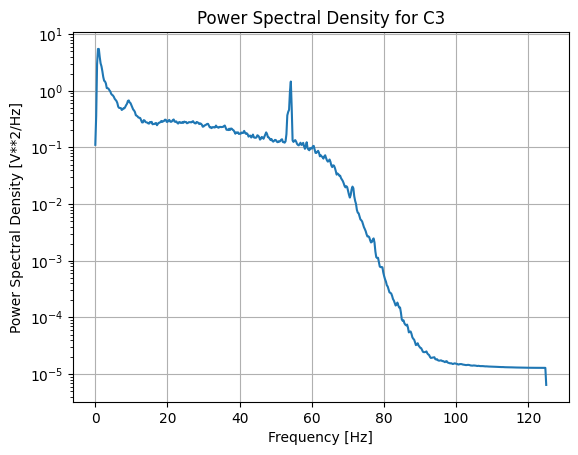

In [38]:
from scipy import signal
import matplotlib.pyplot as plt

# Example for a single channel
f, Pxx = signal.welch(eeg_data['C3'], fs=250, nperseg=1024)
plt.semilogy(f, Pxx)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power Spectral Density [V**2/Hz]')
plt.title('Power Spectral Density for C3')
plt.grid(True)
plt.show()

In [41]:
# import mne
# import numpy as np

# # Example data
# data = np.random.randn(64)  # Example data for 32 channels
# info = mne.create_info(ch_names=channels, sfreq=250, ch_types='eeg')
# evoked = mne.EvokedArray(data[:, np.newaxis], info)

# # Plot topographic map
# evoked.plot_topomap(times=[0], size=3, show=True)

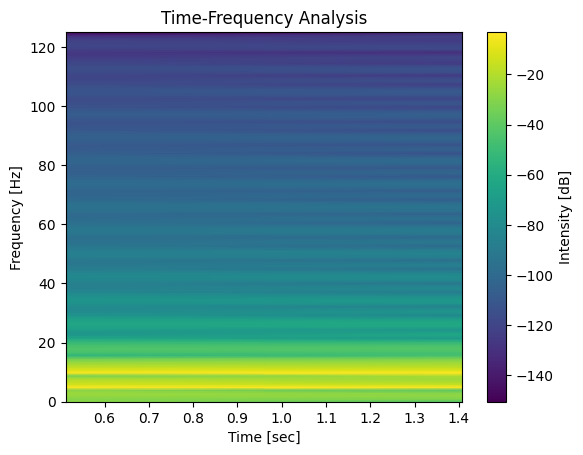

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Example for a single channel
t = np.linspace(0, 1, 500, endpoint=False)
sig = np.sin(2 * np.pi * 10 * t) + np.sin(2 * np.pi * 20 * t)
frequencies, times, Sxx = signal.spectrogram(sig, fs=250)

plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.title('Time-Frequency Analysis')
plt.colorbar(label='Intensity [dB]')
plt.show()

In [43]:
# import matplotlib.pyplot as plt

# # Example: Averaging across trials for a specific channel
# erp = eeg_data.groupby('event').mean()['C3']
# plt.plot(erp)
# plt.xlabel('Time (samples)')
# plt.ylabel('Amplitude (µV)')
# plt.title('Event-Related Potential for C3')
# plt.grid(True)
# plt.show()

KeyError: 'event'

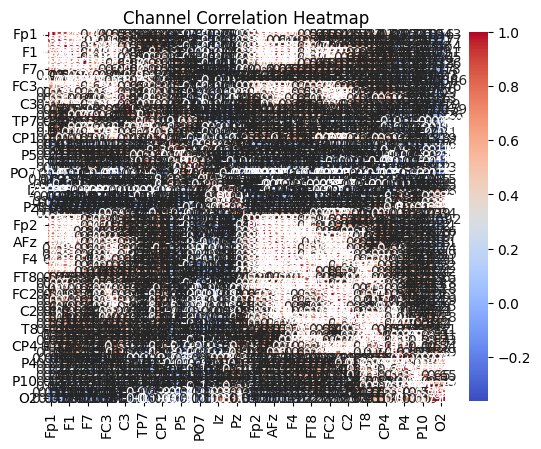

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = eeg_data.corr()

# Plot heatmap
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Channel Correlation Heatmap')
plt.show()

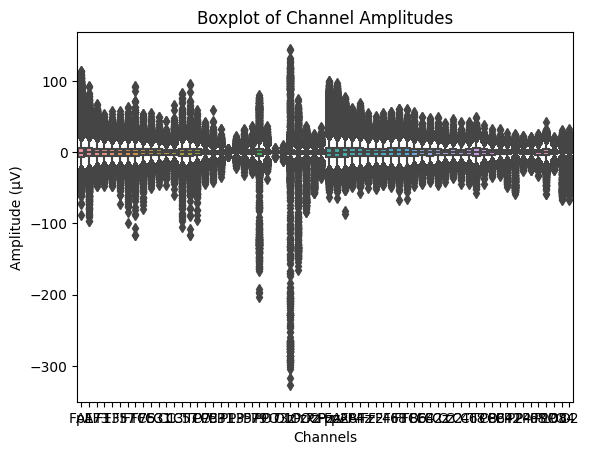

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot boxplot
sns.boxplot(data=eeg_data)
plt.xlabel('Channels')
plt.ylabel('Amplitude (µV)')
plt.title('Boxplot of Channel Amplitudes')
plt.show()

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

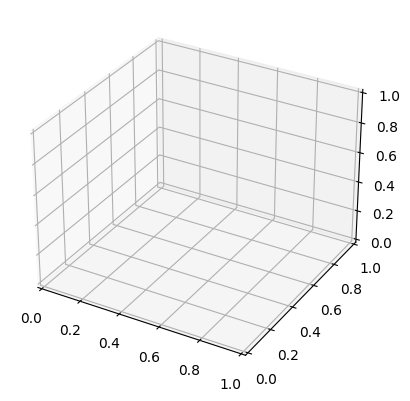

In [46]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# # Example data
# X, Y = np.meshgrid(time_column, channels)
# Z = eeg_data.values.T

# # Plot 3D surface
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(X, Y, Z, cmap='viridis')
# ax.set_xlabel('Time (samples)')
# ax.set_ylabel('Channels')
# ax.set_zlabel('Amplitude (µV)')
# plt.title('3D Surface Plot of EEG Data')
# plt.show()